In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies

In [28]:
# from causal_pyro.query.do_messenger import do
# import pickle
# from scipy import stats
# import scipy

import matplotlib.pyplot as plt

import torch
import numpy as np

import sys
sys.path.append("../../src/")
import time

import pyro
import pyro.distributions as dist

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.utils import get_tspan, LogNormalPrior_propVar
from pyciemss.utils import setup_ax, plot_predictive, plot_trajectory, plot_intervention_line, sideaxis, sideaxishist

from pyciemss.ODE.interventions import parameter_intervention_builder, time_and_state_dependent_intervention_builder, time_dependent_intervention_builder
from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import max_total_infections_SIDARTHE

import warnings
warnings.filterwarnings('ignore')

pyro.set_rng_seed(0)

# Setup Parameters

In [3]:
tspan = get_tspan(1, 100, 100) # Simulation time
N = 1 # Total population
# Initial number of infected and recovered individuals, I0 and R0.
I0, D0, A0, R0, T0, H0, E0, V0 = 200/60e6, 20/60e6, 1/60e6, 2/60e6, 0, 0, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - D0 - A0 - R0 - T0 - H0 - E0 - V0

# Probabilistic Forecasting - Passing unit test 1
There are two ‘unit tests’ we want to pass, to ensure that we understood and can reproduce the published model:

## 1.a Unit Test \#1:

Set the initial values and parameters, as described in the Supplementary Methods section of the publication (pg. 9 of the pdf): 

1. Initial Values: 
* $I = 200/60e6$,
* $D = 20/60e6$, 
* $A = 1/60e6$, 
* $R = 2/60e6$, 
* $T = 0$, 
* $H = 0$, 
* $E = 0$; 
* $S = 1 – I – D – A – R – T – H – E$. 

Let total population = 60e6.
Parameters: $$\alpha = 0.570, \beta = \delta  = 0.011, \gamma = 0.456, \epsilon = 0.171, \theta = 0.371, \zeta = \eta = 0.125, \mu = 0.017, \nu = 0.027, \tau = 0.01, \lambda = \rho = 0.034$$ and $$\kappa = \xi = \sigma = 0.017$$.

### Deterministic forecasting

In [4]:
# Read ODE model and initial setup
from pyciemss.ODE.models import SIDARTHEV

ode_model = SIDARTHEV(N=1,
                 alpha_prior=dist.Delta(torch.tensor (0.570)) ,
                 beta_prior=dist.Delta(torch.tensor (0.011)) ,
                 gamma_prior=dist.Delta(torch.tensor (0.456)) ,
                 delta_prior=dist.Delta(torch.tensor (0.011)) ,
                 epsilon_prior=dist.Delta(torch.tensor (0.171)) ,
                 lamb_prior =dist.Delta(torch.tensor (0.034)) ,
                 zeta_prior=dist.Delta(torch.tensor (0.125)) ,
                 eta_prior=dist.Delta(torch.tensor (0.125)) ,
                 kappa_prior=dist.Delta(torch.tensor (0.017)) ,
                 theta_prior=dist.Delta(torch.tensor (0.371)) ,
                 rho_prior=dist.Delta(torch.tensor (0.034)) ,
                 xi_prior=dist.Delta(torch.tensor (0.017)) ,
                 sigma_prior=dist.Delta(torch.tensor (0.017)) ,
                 mu_prior=dist.Delta(torch.tensor (0.017)) ,
                 nu_prior=dist.Delta(torch.tensor (0.027)) ,
                 tau2_prior=dist.Delta(torch.tensor (0.01)) ,
                 phi_prior=dist.Delta(torch.tensor (0.)) )

initial_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0, V0))
num_samples = 50 # Number of Monte Carlo samples

In [5]:
single_prediction = sample(ode_model, 1, initial_state, tspan)

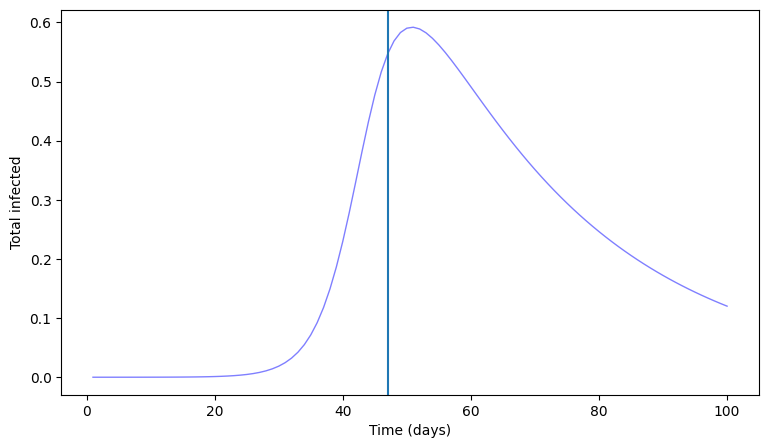

In [6]:
ax = plot_trajectory(single_prediction, tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax.axvline(47)

### Probabilistic forecasting

In [7]:
ode_model = SIDARTHEV(N=1,
                 alpha_prior=LogNormalPrior_propVar(torch.tensor(0.570)) ,
                 beta_prior=LogNormalPrior_propVar(torch.tensor(0.011)) ,
                 gamma_prior=LogNormalPrior_propVar(torch.tensor(0.456)) ,
                 delta_prior=LogNormalPrior_propVar(torch.tensor(0.011)) ,
                 epsilon_prior=LogNormalPrior_propVar(torch.tensor(0.171)) ,
                 lamb_prior =LogNormalPrior_propVar(torch.tensor(0.034)) ,
                 zeta_prior=LogNormalPrior_propVar(torch.tensor(0.125)) ,
                 eta_prior=LogNormalPrior_propVar(torch.tensor(0.125)) ,
                 kappa_prior=LogNormalPrior_propVar(torch.tensor(0.017)) ,
                 theta_prior=LogNormalPrior_propVar(torch.tensor(0.371)) ,
                 rho_prior=LogNormalPrior_propVar(torch.tensor(0.034)) ,
                 xi_prior=LogNormalPrior_propVar(torch.tensor(0.017)) ,
                 sigma_prior=LogNormalPrior_propVar(torch.tensor(0.017)) ,
                 mu_prior=LogNormalPrior_propVar(torch.tensor(0.017)) ,
                 nu_prior=LogNormalPrior_propVar(torch.tensor(0.027)) ,
                 tau2_prior=LogNormalPrior_propVar(torch.tensor(0.01)) ,
                 phi_prior=dist.Delta(torch.tensor (0.)) )

In [8]:
prior_prediction = sample(ode_model, num_samples, initial_state, tspan)

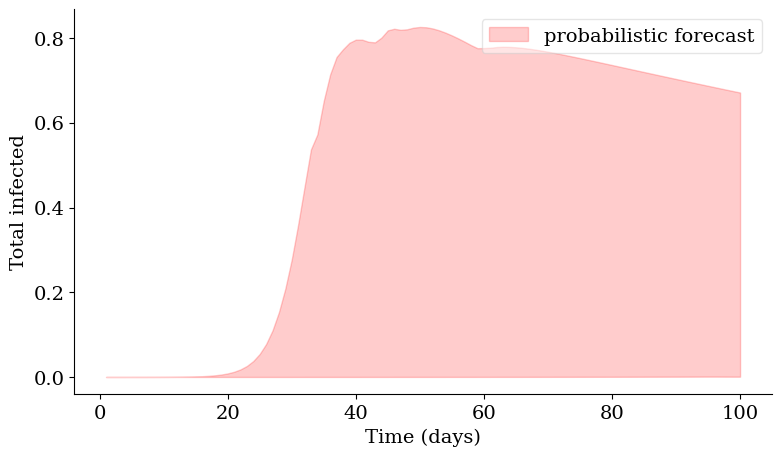

In [19]:
ax1 = plot_predictive(prior_prediction, tspan, ax=setup_ax(), label="probabilistic forecast", color="red")
sideaxis(ax1)

## 2..b.i Policies that prevent infections from exceeding 1/3 of the population

Let’s say our goal is to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population, over the course of the next 100 days. If you could choose only a single intervention (affecting only one parameter), which intervention would let us meet our goal, with minimal change to the intervention parameter? Assume that the intervention will be implemented after one month (t = day 30), and will stay constant after that, over the remaining time period (i.e. the following 70 days). What are 
equivalent interventions of the other two intervention types, that would have the same impact on total infections?

*Note that we started implementing intervention after t=15 days. 

### Problem Formulation
* **Quantity of interest**:  Total infections out of $N=60,000,000$ population
$$I_{total}(t; \mathbf{u}, \mathbf{Z}) = I(t) + D(t) + A(t) + R(t) + T(t)$$

A conservative estimate for the quantity of interest is
$$M(u, Z) = \max_{1\leq t \leq 100} I_{total}(t; \mathbf{u}, \mathbf{Z})/N$$




* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Transmission parameter $\alpha$
    


* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the change in the magnitude of parameter interventions from the initial value $u_\text{init}$ (e.g., $u_\text{init}=\alpha_\text{init}=0.57$ for intervention on $\alpha$ parameter).
    * Constraint - Risk of normalized total infections exceeding the prescribed threshold of $1/3$, $\mathcal{R}( M(\mathbf{u},\mathbf{Z}))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ 
\text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

#### Formulation 1: Optimize for $u=\{\alpha,\beta,\gamma,\delta\}$
\begin{equation} 
\begin{split} 
u^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \lvert u_\text{init}-u \rvert \\ 
\text{s.t.}\ & \mathbb{P}( M(u, \mathbf{Z}) \ge 1/3) \le 0.05
\end{split} 
\end{equation}

Instead of  probability of exceedance, we will use **superquantiles** $\overline{Q}_{\alpha_\text{risk}}$ as the risk measure with risk level determined by $\alpha_\text{risk}=1-0.05=0.95$ (desirable practical and mathematical properties).
#### Formulation 2: Optimize for $u=\{\alpha,\beta,\gamma,\delta\}$
\begin{equation} 
\begin{split} 
u^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \lvert u_\text{init}-u \rvert \\ 
\text{s.t.}\ & \overline{Q}_{0.95}( M(\mathbf{u}, \theta)) \le 1/3 
\end{split} 
\end{equation}

## Custom delayed intervention starting after 15 days

In [10]:
def delayed_intervention_controller(name, x, init_value):
    def delayed_intervention(t, flux):
        if t<15:
            return flux
        else:
            return flux/init_value*x
    return time_and_state_dependent_intervention_builder(name, delayed_intervention, tspan)  

def delayed_intervention_controller_flux(name, x):
    def delayed_intervention(t):
        if t<15:
            return torch.tensor(0.)
        else:
            return x
    return time_dependent_intervention_builder(name, delayed_intervention, tspan) 

### Define optimization problem specifics (shared across optimization problems with different interventions)

In [11]:
RISK_BOUND = 1./3.
N_SAMPLES_OUU = int(5e2)

# Plot settings
co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']

### Exploring the intervention on $\alpha$ and difference between Quantiles and Superquantiles

In [12]:
control_model = ode_model
alpha_init = 0.57
# Control action / intervention
# param_intervention = parameter_intervention_builder("alpha", alpha_init)
# control_model = intervene(ode_model,param_intervention)
INTERVENTION = lambda x: delayed_intervention_controller("SI_flux", torch.from_numpy(np.array([x])), alpha_init)

In [23]:
POLICY = np.array([0.05])
N_SAMPLES = 500

RISK = computeRisk(model=control_model,
                 intervention_fun=INTERVENTION,
                 qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=initial_state,
                 tspan=tspan,
                 guide=None)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)
print('quantile: ', q_sv, '\nalpha-superquantile: ', sq_sv)

quantile:  0.2011916950345039 
alpha-superquantile:  0.3105365455150604


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


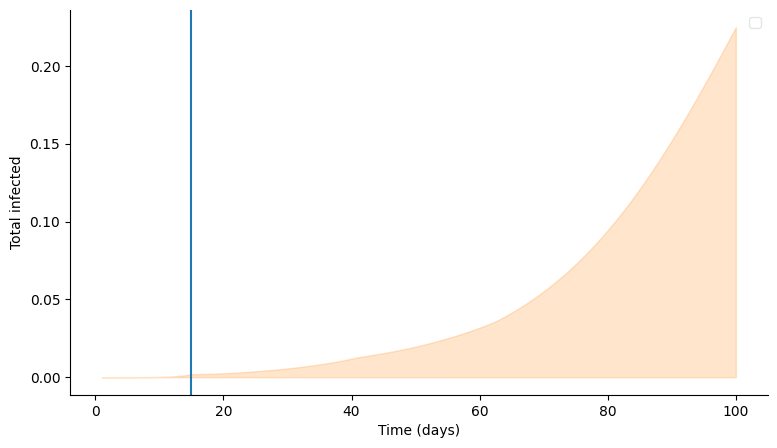

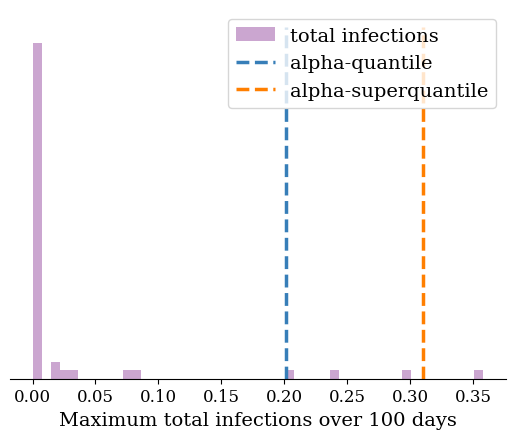

In [14]:
ax = setup_ax()
ax = plot_predictive(sq_dataCube, tspan, ax=ax, color=co[1])
ax.axvline(15)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('Maximum total infections over 100 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})

## Risk-based optimization under uncertainty with intervention on transmission parameters 

**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk (currently using N_SAMPLES_OUU=500), so take the results with a grain of salt.

#### Formulation: Optimize for $u=\{\alpha,\beta,\gamma,\delta\}$
\begin{equation} 
\begin{split} 
u^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \lvert u_\text{init}-u \rvert \\ 
\text{s.t.}\ & \overline{Q}_{0.95}( M(\mathbf{u}, \theta)) \le 1/3 
\end{split} 
\end{equation}

* We show the OUU solution for transmission parameter $\alpha$.

* Note that only controlling transmission parameters $\beta, \gamma,\delta$ without controlling $\alpha$ leads to no feasible policy that can get the infections below the desired threshold.

### Setup and run OUU problem

In [15]:
X_MIN = 0.
X_MAX = 3.
INIT_GUESS = 0.025

# Objective function
OBJFUN = lambda x: np.abs(alpha_init-x)

# Define the risk measure.
RISK = computeRisk(model=control_model,
                    intervention_fun=INTERVENTION,
                    qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                    model_state=initial_state,
                    tspan=tspan,
                    risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
                    num_samples=N_SAMPLES_OUU,
                    guide=None
                    )

# Define problem constraints
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - RISK(x)},

                # bounds on control
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [16]:
MAXITER = 0 # Maximum number of basinhopping iterations: >0 leads to multi-start
MAXFEVAL = 30 # Maximum number of function evaluations for each local optimization step
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES_OUU*(MAXITER+1)*MAXFEVAL:.1f} seconds.")
start_time = time.time()
sq_result_1 = solveOUU(
                     x0=INIT_GUESS,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     maxiter=MAXITER,
                     maxfeval=MAXFEVAL,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal solution:\t{sq_result_1.x}")

# Check for some interventions that lead to no feasible solutions
if sq_result_1.x<0:
    print("No solution found")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 279.8 seconds.
Optimization completed in time 1685.66 seconds. Optimal solution:	0.047625738622044486


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\alpha^*=0.0476$

In [20]:
RISK.num_samples = int(1e3) # Using more samples for risk estimation
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result_1.x)
qois_sq = RISK.qoi(sq_optimal_prediction)
sq_est = RISK.risk_measure(qois_sq)
print('Estimated risk at optimal policy', sq_est)

Estimated risk at optimal policy 0.34450121283531177


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Maximum total infections over 100 days')

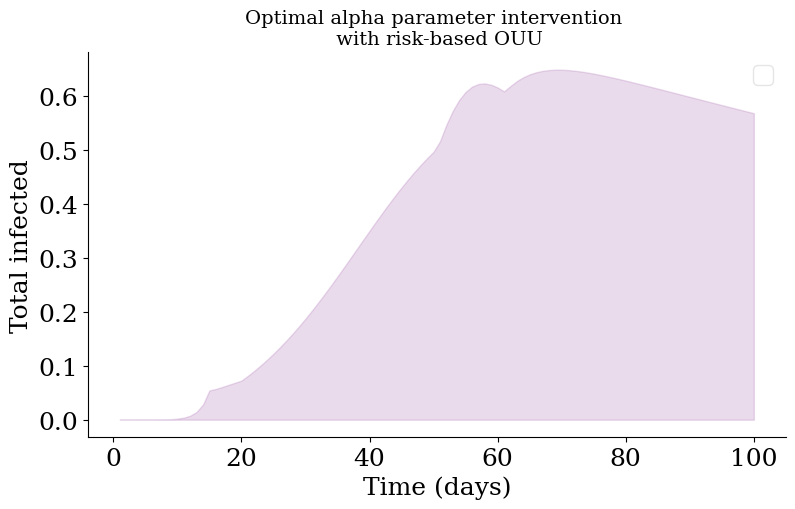

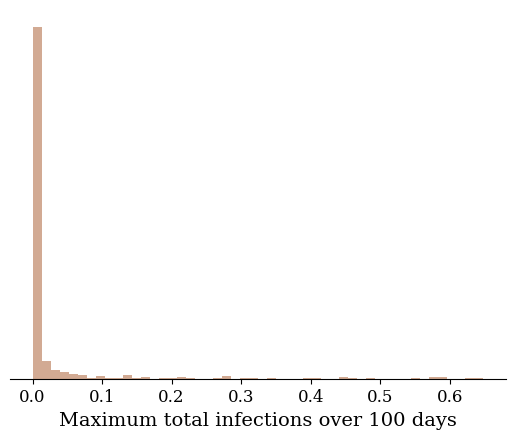

In [18]:
ax = setup_ax()
ax = plot_predictive(sq_optimal_prediction, tspan, ax=ax, color=co[2], ptiles=[0.0,1.])
plt.title("Optimal alpha parameter intervention \n with risk-based OUU", size=14)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.set_xlabel('Maximum total infections over 100 days', size=14)

## Risk-based optimization under uncertainty with intervention on detection parameters $\theta,\epsilon$
* **NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk (currently using N_SAMPLES_OUU=500), so take the results with a grain of salt.

* We show a different OUU problem formulation for this case to highlight the many possible ways of formulating an optimization problem. 


#### Formulation: Optimize $\mathbf{u}=[\epsilon,\theta]$ while constraining $\theta \ge 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^\ast, \theta^\ast= \underset{\{\epsilon,\theta\}\in\mathcal{U}}{\arg\min}\ & \theta + \epsilon \\ \text{s.t.}\ & \overline{Q}_{0.95}( M(\mathbf{u}, \theta)) \le 1/3 , \\
& \theta \ge 2\epsilon
\end{split} 
\end{equation}

### Setup intevention

In [29]:
control_model2 = ode_model
epsilon_init = 0.171
theta_init = 0.371
# Control action / intervention
INTERVENTION2 = lambda x: [delayed_intervention_controller("ID_flux", torch.from_numpy(np.array([x[0]])), epsilon_init),
                    delayed_intervention_controller("AR_flux", torch.from_numpy(np.array([x[1]])), theta_init)]

### Setup and run OUU problem

In [30]:
X_MIN = 0.
X_MAX = 3.
INIT_GUESS = np.array([0.8,2.])

# Objective function.
OBJFUN = lambda x: np.sum(x)  # minimize the value itself

# Define the risk measure.
RISK = computeRisk(model=control_model2,
                    intervention_fun=INTERVENTION2,
                    qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                    model_state=initial_state,
                    tspan=tspan,
                    risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
                    num_samples=N_SAMPLES_OUU,
                    guide=None
                    )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - RISK(x)},
                {'type': 'ineq', 'fun': lambda x: x[1] - 2*x[0]},

                # bounds on control
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [ ]:
MAXITER = 0 # Maximum number of basinhopping iterations: >0 leads to multi-start
MAXFEVAL = 60 # Maximum number of function evaluations for each local optimization step
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES_OUU*(MAXITER+1)*MAXFEVAL:.1f} seconds.")
start_time = time.time()
sq_result_1 = solveOUU(
                     x0=INIT_GUESS,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     maxiter=MAXITER,
                     maxfeval=MAXFEVAL,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal solution:\t{sq_result_1.x}")

# Check for some interventions that lead to no feasible solutions
if sq_result_1.x<0:
    print("No solution found")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 5596.7 seconds.


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\theta^*=$ and $\epsilon^*=$

In [ ]:
RISK.num_samples = int(1e3) # Using more samples for risk estimation
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result_1.x)
qois_sq = RISK.qoi(sq_optimal_prediction)
sq_est = RISK.risk_measure(qois_sq)
print('Estimated risk at optimal policy', sq_est)

In [ ]:
ax = setup_ax()
ax = plot_predictive(sq_optimal_prediction, tspan, ax=ax, color=co[2], ptiles=[0.0,1.])
plt.title("Optimal alpha parameter intervention \n with risk-based OUU", size=14)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.set_xlabel('Maximum total infections over 100 days', size=14)

## Risk-based optimization under uncertainty with intervention on vaccination flux SV_flux
* **NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk (currently using N_SAMPLES_OUU=500), so take the results with a grain of salt.

* We show an OUU problem formulation with intervention on the vaccination fux directly instead of the vaccination parameter. This leads to a more interpretable intervention and the optimal policy is a more practical one that can be implemented in practice.

#### Formulation: Optimize for $u=SV_\text{flux}$
\begin{equation} 
\begin{split} 
u^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & u \\ \text{s.t.}\ & \overline{Q}_{0.95}( M(\mathbf{u}, \theta)) \le 1/3
\end{split} 
\end{equation}

### Setup intevention

In [29]:
control_model3 = ode_model
# Control action / intervention
INTERVENTION3 = lambda x: delayed_intervention_controller_flux("SV_flux", torch.from_numpy(np.array([x])))

### Setup and run OUU problem

In [30]:
X_MIN = 0.
X_MAX = 2.
INIT_GUESS = 0.05

# Objective function.
OBJFUN = lambda x: np.sum(x)  # minimize the value itself

# Define the risk measure.
RISK = computeRisk(model=control_model3,
                    intervention_fun=INTERVENTION3,
                    qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                    model_state=initial_state,
                    tspan=tspan,
                    risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
                    num_samples=N_SAMPLES_OUU,
                    guide=None
                    )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - RISK(x)},

                # bounds on control
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [ ]:
MAXITER = 0 # Maximum number of basinhopping iterations: >0 leads to multi-start
MAXFEVAL = 60 # Maximum number of function evaluations for each local optimization step
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES_OUU*(MAXITER+1)*MAXFEVAL:.1f} seconds.")
start_time = time.time()
sq_result_1 = solveOUU(
                     x0=INIT_GUESS,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     maxiter=MAXITER,
                     maxfeval=MAXFEVAL,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal solution:\t{sq_result_1.x}")

# Check for some interventions that lead to no feasible solutions
if sq_result_1.x<0:
    print("No solution found")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 5596.7 seconds.


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\theta^*=$ and $\epsilon^*=$

In [ ]:
RISK.num_samples = int(1e3) # Using more samples for risk estimation
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result_1.x)
qois_sq = RISK.qoi(sq_optimal_prediction)
sq_est = RISK.risk_measure(qois_sq)
print('Estimated risk at optimal policy', sq_est)

In [ ]:
ax = setup_ax()
ax = plot_predictive(sq_optimal_prediction, tspan, ax=ax, color=co[2], ptiles=[0.0,1.])
plt.title("Optimal alpha parameter intervention \n with risk-based OUU", size=14)
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.set_xlabel('Maximum total infections over 100 days', size=14)